# Name: Nalet

- Please answer the question in the same order as in the assignment and use the same question numbers;
- Don't answer the questions in the code comments. Use the text cells in your notebook;
- Remove clutter such as unused code lines instead of turning them into comments;
- Make sure the right execution order of the notebook cells is from top to bottom. A TA should be able to reproduce your results by simply clicking "Run All" without having to guess which cells should be executed first.

# Assignment 1 ATML 2020
Download the dataset files from ILIAS and put them in the same folder as this notebook.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import os.path
if not os.path.isfile('data/imgs_train.npy'):
  from google.colab import drive
  drive.mount('/content/drive')
  !cp '/content/drive/My Drive/ATML/Assignments/Assignment1/data.zip' .
  !unzip data.zip

images = np.load('data/imgs_train.npy')
labels = np.load('data/labels_train.npy')

test_images = np.load('data/imgs_test.npy')
test_labels = np.load('data/labels_test.npy')

## Task 1. Prepare data for training and model selection

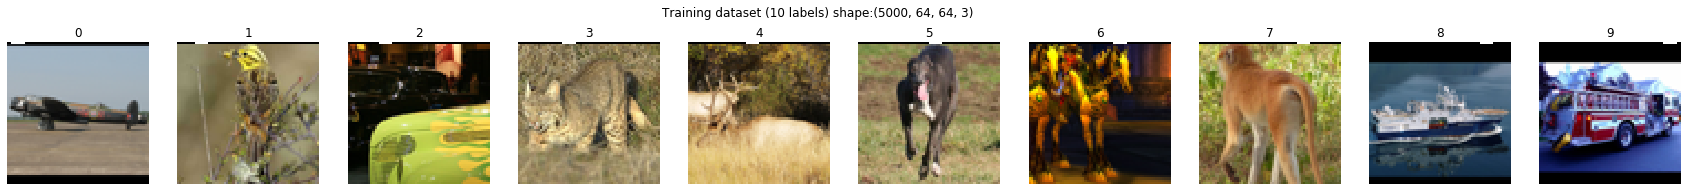

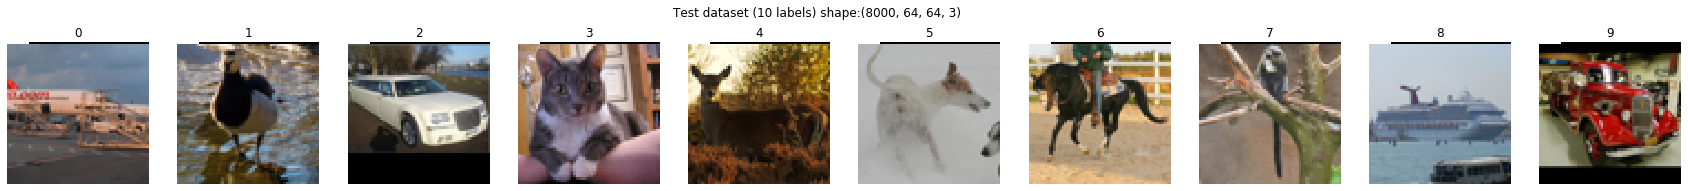

In [13]:
%matplotlib inline

def plot_image(title, images, labels):
  img_choices = []
  for label in np.unique(labels):
    img_choices.append(np.where(labels==label)[0][0])

  fig, axs = plt.subplots(1, 10, figsize=(30, 3))
  for ax, selected_img in zip(axs, img_choices):
      ax.imshow(images[selected_img])
      ax.axis('off')
      ax.set_title(str(labels[selected_img]))

  fig.suptitle(title + str(images.shape))
  fig.subplots_adjust(top=0.85)    
  plt.show()

plot_image('Training dataset (10 labels) shape:', images, labels)
plot_image('Test dataset (10 labels) shape:', test_images, test_labels)

In [0]:
import torch
from torch.utils.data import Dataset
from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize, ToTensor, Normalize, Compose, ToPILImage
class NumpyDataset(Dataset):
    def __init__(self, data, target):
        self.data = data
        self.target = target
        
    def __getitem__(self, index):
        datapoint = self.data[index]
        target = self.target[index]
        return datapoint, target
    
    def __len__(self):
        return len(self.data)

transforms = Compose([ToPILImage(), 
                      ToTensor(), # Converts to Tensor, scales to [0, 1] float (from [0, 255] int)
                      Normalize(mean=(0.5, 0.5, 0.5,), std=(0.5, 0.5, 0.5))]) # scales to [-1.0, 1.0]

images_ = []
test_images_ = []

for img in images: images_.append(transforms(img))
for img in test_images: test_images_.append(transforms(img))

images = images_
test_images = test_images_

train_dataset = NumpyDataset(images, labels)

In [0]:
from torch.utils.data import DataLoader
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4) #num_workers = n - how many threads in background for efficient loading

val_dataset = NumpyDataset(test_images, test_labels)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

## Task 2. Train a linear classification model

In [0]:
import torch.nn as nn
class LinearModel(nn.Module):
    
    def __init__(self, input_dim):
        super(LinearModel, self).__init__()
        self.fc = nn.Linear(input_dim, 10, bias=True) # outputs 2 values - score for cat and score for dog
        
    def forward(self, input):
        out = input.view(input.size(0), -1) # convert batch_size x 3 x imH x imW to batch_size x (3*imH*imW)
        out = self.fc(out) # Applies out = input * A + b. A, b are parameters of nn.Linear that we want to learn
        return out

def train_epoch(model, train_dataloader, optimizer, loss_fn):
    losses = []
    correct_predictions = 0
    # Iterate mini batches over training dataset
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        # Run predictions
        output = model(images)
        # Set gradients to zero
        optimizer.zero_grad()
        # Compute loss
        loss = loss_fn(output, labels)
        # Backpropagate (compute gradients)
        loss.backward()
        # Make an optimization step (update parameters)
        optimizer.step()
        # Log metrics
        losses.append(loss.item())
        predicted_labels = output.argmax(dim=1)
        correct_predictions += (predicted_labels == labels).sum().item()
    accuracy = 100.0 * correct_predictions / len(train_dataloader.dataset)
    # Return loss values for each iteration and accuracy
    mean_loss = np.array(losses).mean()
    return mean_loss, accuracy

def evaluate(model, dataloader, loss_fn):
    losses = []
    correct_predictions = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            # Run predictions
            output = model(images)
            # Compute loss
            loss = loss_fn(output, labels)
            # Save metrics
            predicted_labels = output.argmax(dim=1)
            correct_predictions += (predicted_labels == labels).sum().item()
            losses.append(loss.item())
    mean_loss = np.array(losses).mean()
    accuracy = 100.0 * correct_predictions / len(dataloader.dataset)
    # Return mean loss and accuracy
    return mean_loss, accuracy

def train(model, train_dataloader, val_dataloader, optimizer, n_epochs, loss_fn):
    # We will monitor loss functions as the training progresses
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(n_epochs):
        model.train()
        train_loss, train_accuracy = train_epoch(model, train_dataloader, optimizer, loss_fn)
        model.eval()
        val_loss, val_accuracy = evaluate(model, val_dataloader, loss_fn)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        print('Epoch {:02d}/{:02d}: train_loss: {:.4f}, train_accuracy: {:08.4f}, val_loss: {:.4f}, val_accuracy: {:.4f}'.format(epoch+1, n_epochs,
                                                                                                      train_losses[-1],
                                                                                                      train_accuracies[-1],
                                                                                                      val_losses[-1],
                                                                                                      val_accuracies[-1]))
    return train_losses, val_losses, train_accuracies, val_accuracies

In [0]:
def train_linear(learning_rate,n_epochs):
    print('Run with ' + str(learning_rate) + ' learning rate and number of epochs: ' + str(n_epochs))
    model = LinearModel(64*64*3)
    model = model.to(device)
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    train_losses, val_losses, train_accuracies, val_accuracies = train(model, train_dataloader, val_dataloader, optimizer, n_epochs, loss_fn)

    return learning_rate,n_epochs, train_losses, val_losses, train_accuracies, val_accuracies, model

In [58]:

result_test_001_10 = train_linear(0.001,10)
result_test_0001_20 = train_linear(0.0001,20)
result_test_0001_30 = train_linear(0.00001,30)

Run with 0.001 learning rate and number of epochs: 10
Epoch 01/10: train_loss: 1.5772, train_accuracy: 061.2400, val_loss: 1.9099, val_accuracy: 29.3875
Epoch 02/10: train_loss: 0.9041, train_accuracy: 092.1800, val_loss: 1.9561, val_accuracy: 25.4250
Epoch 03/10: train_loss: 0.5807, train_accuracy: 097.2000, val_loss: 2.0366, val_accuracy: 21.1625
Epoch 04/10: train_loss: 0.4062, train_accuracy: 098.7600, val_loss: 2.1638, val_accuracy: 16.9750
Epoch 05/10: train_loss: 0.3010, train_accuracy: 099.4600, val_loss: 2.2616, val_accuracy: 15.0375
Epoch 06/10: train_loss: 0.2367, train_accuracy: 099.7200, val_loss: 2.3926, val_accuracy: 12.6375
Epoch 07/10: train_loss: 0.1914, train_accuracy: 099.8600, val_loss: 2.4726, val_accuracy: 12.2250
Epoch 08/10: train_loss: 0.1594, train_accuracy: 099.9400, val_loss: 2.5511, val_accuracy: 11.5875
Epoch 09/10: train_loss: 0.1363, train_accuracy: 099.9600, val_loss: 2.6358, val_accuracy: 11.2000
Epoch 10/10: train_loss: 0.1186, train_accuracy: 099.96

#### Report below:
**REPORT** *plots, validation losses and accuracies for different learning rates, learning rate for the selected best performing model*

## Task 3. Evaluate on the test set

In [0]:
def plot_results(train_results):

    learning_rate,n_epochs, train_losses, val_losses, train_accuracies, val_accuracies, model = train_results

    print('Results from ' + str(learning_rate) + ' learning rate and number of epochs: ' + str(n_epochs))

    parameters_t = list(model.parameters()).copy()

    maxVal = parameters_t[0].max()
    minVal = abs(parameters_t[0].min())
    maxVal = max(maxVal,minVal)
    parameters_t[0] = parameters_t[0] / maxVal
    parameters_t[0] = parameters_t[0] / 2
    parameters_t[0] = parameters_t[0] + 0.5

    fig, axs = plt.subplots(1, 10, figsize=(30, 3))
    for ax, w_index in zip(axs, range(0,10)):
        ax.imshow(parameters_t[0][w_index].detach().numpy().reshape((64,64,3)))
        ax.axis('off')
        ax.set_title(w_index + 1)

    fig.suptitle("Weights of each layer")
    fig.subplots_adjust(top=0.85)    
    plt.show()
    
    
    fig, axs = plt.subplots(1, 2,figsize=(15, 4))
    
    axs[0].plot(np.arange(n_epochs), train_losses)
    axs[0].plot(np.arange(n_epochs), val_losses)
    axs[0].legend(['train_loss', 'val_loss'])
    axs[0].set_xlabel('epoch')
    axs[0].set_ylabel('loss value')
    axs[0].set_title('Train/val loss')

    axs[1].plot(np.arange(n_epochs), train_accuracies)
    axs[1].plot(np.arange(n_epochs), val_accuracies)
    axs[1].legend(['train_acc', 'val_acc'])
    axs[1].set_xlabel('epoch')
    axs[1].set_ylabel('accuracy')
    axs[1].set_title('Train/val accuracy')

    plt.show()

Results from 0.001 learning rate and number of epochs: 10


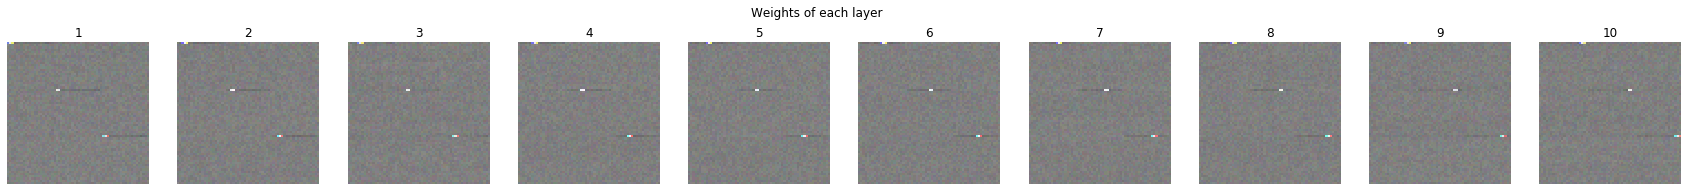

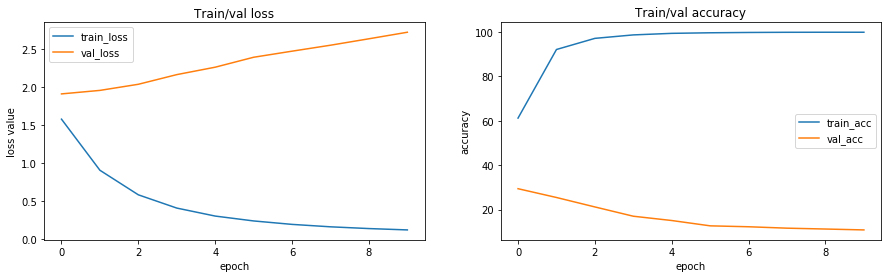

Results from 0.0001 learning rate and number of epochs: 20


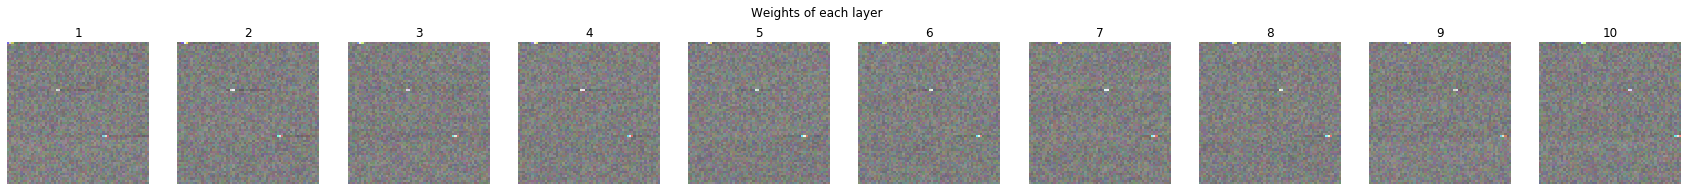

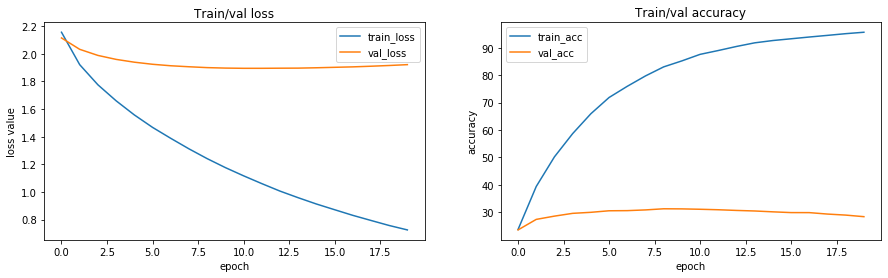

Results from 1e-05 learning rate and number of epochs: 30


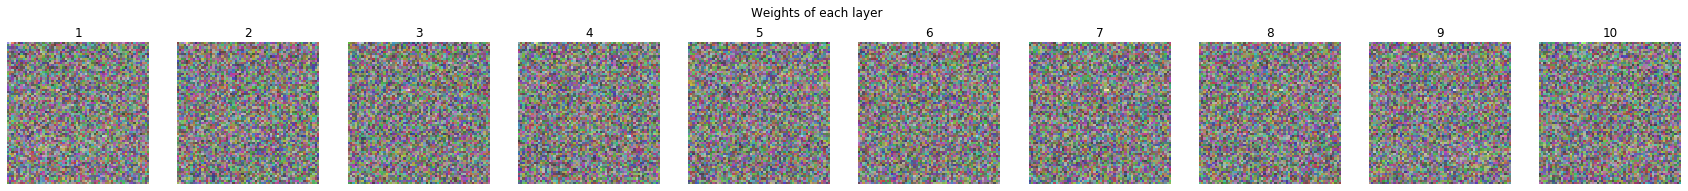

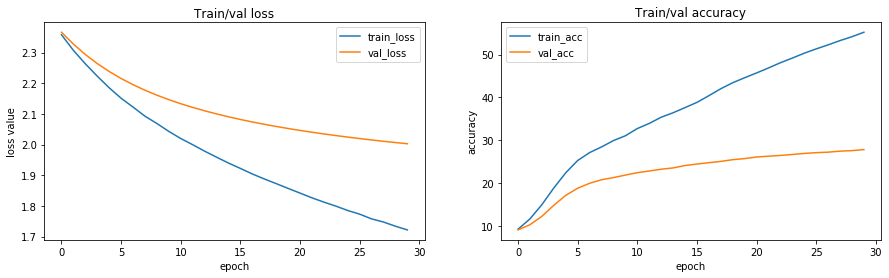

In [73]:
plot_results(result_test_001_10)
plot_results(result_test_0001_20)
plot_results(result_test_0001_30)

#### Report below:
**REPORT**:
*Compare validation and test acccuracy. Comment on differences.  
How are test images different from train images?  
Visualize weights of your best linear model. What did the model learn? How does it distinguish images? Why does it fail on test images?*

## Task 4. Fix the observed problem

In [0]:
# write your code

#### Report below
*Traning and validation loss and accuracy for different learning rates  
Learning rate of the best model  
Test loss and accuracy for the best model  
Compare training, val and test loss and accuracy with the previous model  
Visualize weights of the new model, comment on the differences*
